#### Paquetes necesarios

In [77]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import pytesseract
from pytesseract import Output 
import re

#### Método para mostrar imágenes con matplotlib

In [78]:
def plot_images(img1, img2, title1="", title2=""):
    fig = plt.figure(figsize=[15,15])
    ax1 = fig.add_subplot(121)
    ax1.imshow(img1, cmap="gray")
    ax1.set(xticks=[], yticks=[], title=title1)
    ax2 = fig.add_subplot(122)
    ax2.imshow(img2, cmap="gray")
    ax2.set(xticks=[], yticks=[], title=title2)

#### Método para corregir formato de la matrícula

In [ ]:
def validar_y_corregir_matricula(matricula):
    # Definir el patrón de la matrícula "0000 AAA"
    patron_matricula = re.compile(r'^\d{4}\s[A-Z]{3}$')

    if patron_matricula.match(matricula):
        # La matrícula cumple con el formato
        return matricula
    else:
        # La matrícula no cumple con el formato, intentar corregirla
        matricula_corregida = re.sub(r'^\s*.*?(\d{4}\s[A-Z]{3}).*$', r'\1', matricula)
        return matricula_corregida


0: 384x640 1 car, 84.2ms
Speed: 6.4ms preprocess, 84.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Matrícula: 9645 LZG



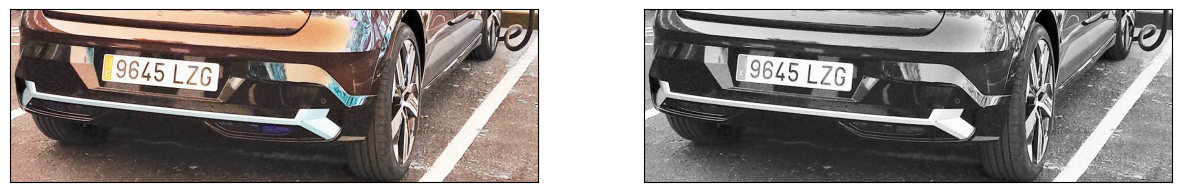

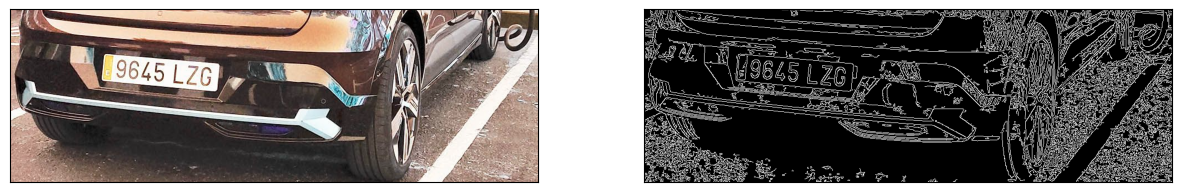

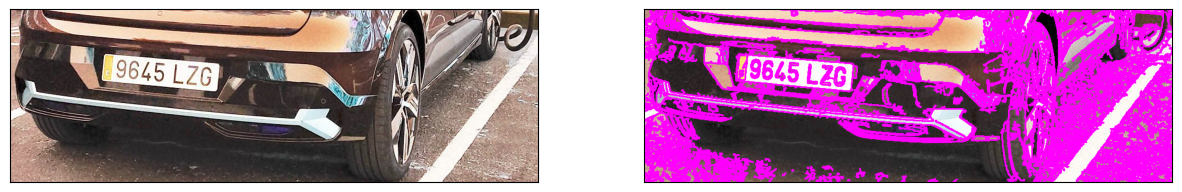

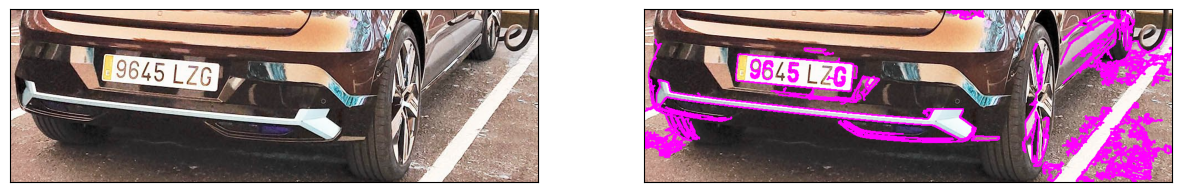

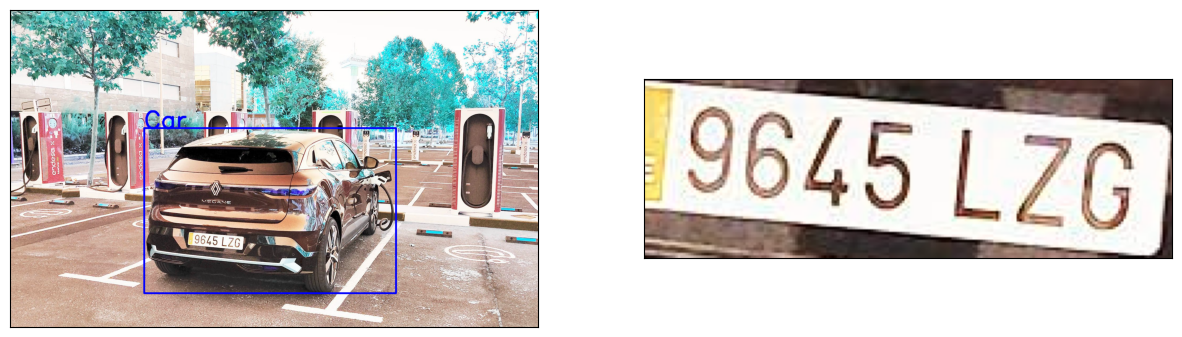

In [76]:
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract'

model_car = YOLO('yolov8n.pt')






# Guardamos imagen en variable
coche = cv2.imread("coche7.jpeg")

plates = []

# Detectar coches
results_cars = model_car(coche)

# Para cada detección de coche
for r_car in results_cars:
    boxes_car = r_car.boxes

    for box_car in boxes_car:
        if int(box_car.cls[0]) == 2:
            # Coordenadas del cuadro del coche
            x1_car, y1_car, x2_car, y2_car = box_car.xyxy[0]

            # Definir la región inferior para buscar matrículas
            roi_bottom = coche[int((y1_car + y2_car) / 2):int(y2_car), int(x1_car):int(x2_car)]

            # Convertir la región a escala de grises
            gray_roi_bottom = cv2.cvtColor(roi_bottom, cv2.COLOR_BGR2GRAY)

            plot_images(roi_bottom, gray_roi_bottom)

            # blur = cv2.bilateralFilter(gray_roi_bottom,12,50,50)

            # plot_images(gray_roi_bottom, blur)

            edges = cv2.Canny(roi_bottom, 30, 200)
            plot_images(roi_bottom, edges)

            cnts, new = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

            image_copy = roi_bottom.copy()

            _ = cv2.drawContours(image_copy, cnts, -1, (255,0,255),2)

            plot_images(roi_bottom, image_copy)

            cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:30]

            image_copy2 = roi_bottom.copy()

            _ = cv2.drawContours(image_copy2, cnts, -1, (255,0,255),2)

            plot_images(roi_bottom, image_copy2)

            plate = None
            for c in cnts:
                perimeter = cv2.arcLength(c, True)
                edges_count = cv2.approxPolyDP(c, 0.02 * perimeter, True)
                if len(edges_count) == 4:
                    x,y,w,h = cv2.boundingRect(c)
                    x, y, w, h = int(x + x1_car), int(y + (y1_car + y2_car) / 2), int(w), int(h)
                    plate = coche[y:y+h, x+10:x+w]
                    break

            # Dibuja el contenedor y clase
            cv2.rectangle(coche, (int(x1_car), int(y1_car)), (int(x2_car), int(y2_car)), (0, 0, 255), 5)
            cv2.putText(coche, "Car" , [int(x1_car), int(y1_car)], cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 8)

            plot_images(coche, plate)

            text = pytesseract.image_to_string(plate, config='--psm 8', output_type=Output.STRING)

            text = validar_y_corregir_matricula(text)

            print("Matrícula:", text)